<a href="https://colab.research.google.com/github/eddson90/tareas_data_science/blob/main/statistical-learning-2/proyecto-final/parte2/Parte2_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Parte 2: Red Convolucional (CNN)**

## Proyecto Final: Implementación de Modelos de Deep Learning
---

Statistical Learning II

Universidad Galileo

Eddson Sierra

## Carga inicial de librerías

In [1]:
pip install pickle5

     |████████████████████████████████| 132 kB 5.3 MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219305 sha256=384c61860abd085af92694807971d2006453b95db1552887683d3def0f767ea4
  Stored in directory: /root/.cache/pip/wheels/7e/6a/00/67136a90d6aca437d806d1d3cedf98106e840c97a3e5188198
Successfully built pickle5


In [2]:
import pandas as pd
import numpy as np
import pickle5 as pickle
import time
import matplotlib.pyplot as plt
import cv2

## Carga de datos

Importamos el archivo pickle con el dataframe que corresponde a las imágenes:

In [6]:
with open('/content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Data_Spiders/df.pickle','rb') as fid:
  data = pickle.load(fid)

# eliminamos dos columnas innecesarias luego de cargar los datos
data = data.drop(['level_0','index'], axis = 1)
data.head(3)

,url,date,content,renderedContent,id,user,conversationId,outlinks,quotedTweet,mentionedUsers,hashtags,mentionedUserName,picture_url,label_IM
0,https://twitter.com/Arachno_Cosas/status/13204...,2021-09-14 13:46:10+00:00,"¡Hola, @TopoGigo6! Gracias por compartir. Pert...","¡Hola, @TopoGigo6! Gracias por compartir. Pert...",1437774676604985351,"{'_type': 'snscrape.modules.twitter.User', 'us...",1437774676604985351,[https://twitter.com/TopoGigo6/status/14376763...,"{'_type': 'snscrape.modules.twitter.Tweet', 'u...","[{'_type': 'snscrape.modules.twitter.User', 'u...","[Corinnidae, NIM]",TopoGigo6,https://pbs.twimg.com/media/E_Om-6dWUAALKL9?fo...,NIM
1,https://twitter.com/Arachno_Cosas/status/13204...,2021-09-14 13:42:56+00:00,"¡Hola, @Elwestrand! Gracias por compartir. Per...","¡Hola, @Elwestrand! Gracias por compartir. Per...",1437773863627149314,"{'_type': 'snscrape.modules.twitter.User', 'us...",1437773863627149314,[https://twitter.com/Elwestrand/status/1437712...,"{'_type': 'snscrape.modules.twitter.Tweet', 'u...","[{'_type': 'snscrape.modules.twitter.User', 'u...","[Thomisidae, NIM]",Elwestrand,https://pbs.twimg.com/media/E_PH0fbXEAMPYi5?fo...,NIM
2,https://twitter.com/Arachno_Cosas/status/13204...,2021-09-14 13:39:45+00:00,"¡Hola, @ddiazgar76! Gracias por la consulta. P...","¡Hola, @ddiazgar76! Gracias por la consulta. P...",1437773064843010057,"{'_type': 'snscrape.modules.twitter.User', 'us...",1437773064843010057,[https://twitter.com/ddiazgar76/status/1437753...,"{'_type': 'snscrape.modules.twitter.Tweet', 'u...","[{'_type': 'snscrape.modules.twitter.User', 'u...","[Oxyopidae, Peucetia, NIM]",ddiazgar76,https://pbs.twimg.com/media/E_PtC1OWYAox7UL?fo...,NIM


El nombre de cada imagen corresponde al id de Tweet en el dataframe:

In [7]:
indice = 1
ejemplo = str(data['id'][indice])
strImg = '/content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Data_Spiders/Imagenes/'+ejemplo+'.png'
data['outlinks'][indice]

['https://twitter.com/Elwestrand/status/1437712417098711042']

'¡Hola, @Elwestrand! Gracias por compartir. Pertenece a la familia #Thomisidae, posiblemente del género «Thomisius». No son consideradas de importancia médica #NIM✅ Saludos https://t.co/vUaVvkMHOn'

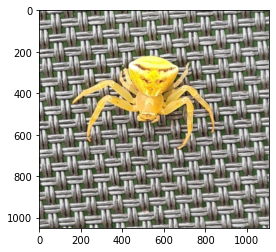

In [8]:
imagen = cv2.imread(strImg)
imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
plt.imshow(imagen)
data['content'][indice]

La columna 'label_IM' indica la etiqueta correspondiente a la importancia médica de la especie:

In [9]:
np.unique(data['label_IM'])

array(['IM', 'NIM'], dtype=object)

## Preparación de datos

### Procesamiento de imágenes con OpenCV

Creamos una función que permite crear tres listas: una de imagenes procesadas (todas del mismo tamaño y normalizadas), una de las etiquetas y otra con el contenido de cada Tweet (esta última se usará en la parte 3). 

In [23]:
def create_dataset(img_path, ancho, largo):
  id_list = data['id'].to_list()
  label_list = data['label_IM'].to_list()
  content_list =data['content'].to_list()

  img_data_array = []
  labels_array = []
  tweet_content_array = []

  for i in range(len(id_list)): # range(len(id_list)) # largo de toda la lista de id's por cuestiones de tiempo se usan 100 imagenes
    try:
      img = cv2.imread(img_path+'/'+str(id_list[i])+'.png', cv2.COLOR_BGR2RGB)
      resized = cv2.resize(img, (ancho,largo), interpolation = cv2.INTER_AREA)
      resized = np.array(resized)
      resized = resized.astype('float32')
      resized = resized/255
      img_data_array.append(resized)
      labels_array.append(label_list[i]) 
      tweet_content_array.append(content_list[i])
    except:
      continue
  return img_data_array, labels_array, tweet_content_array

In [29]:
strDs = '/content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Data_Spiders/Imagenes'
img_data, class_name, tweet_content = create_dataset(strDs, 128,128)

In [30]:
len(img_data), len(class_name), len(tweet_content)

(5574, 5574, 5574)

¡Hola, @TopoGigo6! Gracias por compartir. Pertenece a la familia #Corinnidae probablemente. No son consideradas de importancia médica #NIM✅ Saludos https://t.co/hwXi74WiLs


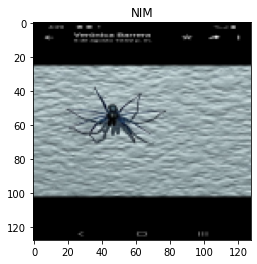

In [31]:
indice = 0
plt.imshow(img_data[indice])
plt.title(class_name[indice])
print(tweet_content[indice])

#### Guardar los datos generados a un archivo pickle

In [32]:
with open('/content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Parte2_CNN/img_data_file.pkl' , 'wb') as f:
  pickle.dump(img_data,f)

In [33]:
with open('/content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Parte2_CNN/class_name_file.pkl' , 'wb') as f:
  pickle.dump(class_name,f)

In [34]:
with open('/content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Parte2_CNN/tweet_content_file.pkl' , 'wb') as f:
  pickle.dump(tweet_content,f)

Creamos una función para cargar las listas desde los archivos pickle:

In [10]:
def load_from_pk(file_name):
  pickle_file = open(file_name, "rb")
  #objects = []
  while True:
      try:
          #objects.append(pickle.load(pickle_file))
          salida = pickle.load(pickle_file)
      except EOFError:
          break
  pickle_file.close()

  return salida

Cargamos los datos desde los archivos pickle: (esto ayuda a retomar el trabajo desde donde se haya quedado para evitar tener que correr la función que crea el dataset de nuevo). 

In [11]:
img_data = load_from_pk('/content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Parte2_CNN/img_data_file.pkl')
class_name = load_from_pk('/content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Parte2_CNN/class_name_file.pkl')

### Encoding de etiquetas

In [12]:
label_dict = {'NIM':0, 'IM':1}
label_dict

{'IM': 1, 'NIM': 0}

In [13]:
target_class = [label_dict[class_name[i]] for i in range(len(class_name))]

Finalmente, convertimos las listas en arrays de Numpy:

In [14]:
img_array = np.array(img_data)
class_array = np.array(target_class).reshape(-1,1)

Validamos la forma de los arreglos y los valores codificados en el arreglo de etiquetas:

In [15]:
img_array.shape, class_array.shape

((5574, 128, 128, 3), (5574, 1))

In [16]:
np.unique(class_array)

array([0, 1])

### Separación de datos

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
x_train, x_test, y_train, y_test = train_test_split(img_array, class_array, train_size = 0.80, random_state = 2021)

In [19]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = 0.9, random_state = 2021)

In [20]:
print("X Rows: x_train= {}, x_test= {}, x_val= {}".format(x_train.shape[0], x_test.shape[0], x_val.shape[0]))
print("Y Rows: y_train= {}, y_test= {}, y_val= {}".format(y_train.shape[0], y_test.shape[0], y_val.shape[0]))

X Rows: x_train= 4013, x_test= 1115, x_val= 446
Y Rows: y_train= 4013, y_test= 1115, y_val= 446


## Red Neuronal Convolucional (CNN)

### Importar TensorFlow y Keras

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import MaxPool2D
from keras.layers import AveragePooling2D
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from keras import metrics

### Definición de arquitectura

Se utiliza una arquitectura AlexNet(2012) sin dropout y con batch normalization.

In [20]:
initializer = tf.keras.initializers.GlorotNormal()

cnn = Sequential([
                  Conv2D(filters=16, kernel_size=(11,11), activation='relu', input_shape=(128,128,3)),
                  BatchNormalization(),
                  MaxPool2D(pool_size=(3,3)),
                  Conv2D(filters=16, kernel_size=(5,5), activation='relu', input_shape=(128,128,3)),
                  BatchNormalization(),
                  MaxPool2D(pool_size=(3,3)),
                  Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)),
                  BatchNormalization(),
                  MaxPool2D(pool_size=(3,3)),

                  Flatten(),
                  Dense(units=4096, activation='relu', kernel_initializer=initializer),
                  BatchNormalization(),
                  Dense(units=4096, activation='relu', kernel_initializer=initializer),
                  BatchNormalization(),
                  Dense(units=1000, activation='relu'),
                  BatchNormalization(),
                  Dense(units=1, activation='sigmoid')
])

In [21]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 118, 16)      5824      
_________________________________________________________________
batch_normalization (BatchNo (None, 118, 118, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 39, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 35, 35, 16)        6416      
_________________________________________________________________
batch_normalization_1 (Batch (None, 35, 35, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 16)          2

## Parámetros de optimización

In [22]:
cnn.compile(optimizer = RMSprop(learning_rate=0.001), 
            loss = tf.keras.losses.BinaryCrossentropy(from_logits=False), 
            metrics = ['accuracy',
                       tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

## Entrenamiento, validación y evaluación

Creamos una función que entrena la red neuronal de acuerdo a los parámetros epochs, step_per_epoch, batch_size; luego valida los resultados en el dataset de validación, guarda el modelo en un directorio y finalmente evalúa la red en los datos de prueba devolviendo un dataframe con el nombre del modelo y los resultados de las métricas en el dataset de pruebas.

Internamente, la función también crea un checkpoint de los mejores steps del modelo y los guarda en un directorio a través de un callback.

In [23]:
def train_val(epochs, steps_per_epoch, batch_size, verbose):
  # Definición de Callbacks
  model_checkpoint =  tf.keras.callbacks.ModelCheckpoint(
      filepath = '/content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Parte2_CNN/Checkpoints/checkpoint_e-{epoch:02d}_-val_acc-{val_accuracy:.2f}.h5',
      save_weights_only=False,
      monitor='val_accuracy',
      mode='max',
      save_best_only=True,
      save_freq='epoch',
      verbose=verbose)

  myCallbacks = [model_checkpoint]

  cnn.fit(x_train, y_train, 
          epochs=epochs,
          batch_size = batch_size,
          steps_per_epoch=steps_per_epoch,
          validation_data = (x_val, y_val),
          verbose = verbose,
          callbacks=myCallbacks
          )

  # Guardar el modelo con el timestamp de ejecución
  timestamp = time.strftime('%Y%m%d_%H%M%S', time.localtime(time.time()))
  cnn.save('/content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Parte2_CNN/Models/cnn_'+str(timestamp)+'_bs='+str(batch_size)+'.h5')

  # Generar dataframe con métricas de evaluación del modelo
  model_name = 'cnn_'+str(timestamp)+'_bs='+str(batch_size)+'_ep='+str(epochs)+'_spe='+str(steps_per_epoch)

  bitacora = pd.DataFrame(np.hstack((model_name,np.array(cnn.evaluate(x_test, y_test, verbose=0)))).reshape(1,6), 
                          columns = ['name','loss','accuracy','binary_accuracy','precision','recall'])
  # calcular el f1 score
  try:
    f1score = 2.0*(float(bitacora['precision'])*float(bitacora['recall']))/(float(bitacora['precision'])+float(bitacora['recall']))
  except:
    f1score = 0.0
  bitacora['f1_score'] = f1score

  return bitacora

In [ ]:
train_val(epochs=50, steps_per_epoch=20, batch_size=4, verbose=1)

Epoch 1/50
20/20 [==============================] - 1s 67ms/step - loss: 0.5362 - accuracy: 0.8125 - binary_accuracy: 0.8125 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 0.4704 - val_accuracy: 0.8072 - val_binary_accuracy: 0.8072 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00

Epoch 00001: val_accuracy improved from -inf to 0.80717, saving model to /content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Parte2_CNN/Checkpoints/checkpoint_e-01_-val_acc-0.81.h5
Epoch 2/50
20/20 [==============================] - 1s 59ms/step - loss: 0.5997 - accuracy: 0.7375 - binary_accuracy: 0.7375 - precision_1: 0.4286 - recall_1: 0.1500 - val_loss: 0.7844 - val_accuracy: 0.8072 - val_binary_accuracy: 0.8072 - val_precision_1: 0.5000 - val_recall_1: 0.0116

Epoch 00002: val_accuracy did not improve from 0.80717
Epoch 3/50
20/20 [==============================] - 1s 57ms/step - loss: 0.8033 - accuracy: 0.7375 - binary_accuracy: 0.7375 - precision_1: 0.0000e+00 - recall_1: 0.0

,name,loss,accuracy,binary_accuracy,precision,recall,f1_score
0,cnn_20210922_123759_bs=4_ep=50_spe=20,0.6572016477584839,0.7892376780509949,0.7892376780509949,0.10638298094272614,0.02525252476334572,0.040816


### Experimentación

In [24]:
#cnn1 = train_val(epochs=100, steps_per_epoch=20, batch_size=4, verbose=0)
#cnn2 = train_val(epochs=100, steps_per_epoch=20, batch_size=8, verbose=0)
#cnn3 = train_val(epochs=100, steps_per_epoch=30, batch_size=16, verbose=0)
#cnn4 = train_val(epochs=100, steps_per_epoch=40, batch_size=64, verbose=0)
#cnn5 = train_val(epochs=150, steps_per_epoch=30, batch_size=8, verbose=0)
#cnn6 = train_val(epochs=200, steps_per_epoch=30, batch_size=4, verbose=0)
#cnn7 = train_val(epochs=300, steps_per_epoch=35, batch_size=16, verbose=0)
cnn8 = train_val(epochs=300, steps_per_epoch=60, batch_size=32, verbose=0)

In [25]:
with open('/content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Parte2_CNN/df_metricas_cnn8.pkl' , 'wb') as f:
  pickle.dump(cnn8,f)

In [26]:
cnn8

,name,loss,accuracy,binary_accuracy,precision,recall,f1_score
0,cnn_20210923_042647_bs=32_ep=300_spe=60,2.0339372158050537,0.7946188449859619,0.7946188449859619,0.385185182094574,0.2626262605190277,0.312312


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Parte2_CNN/df_metricas.pkl' , 'wb') as f:
  pickle.dump(resumen,f)

Cargamos los modelos generados en el entrenamiento y validación:

In [4]:
exp1 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Parte2_CNN/Models/cnn_20210922_171059_bs=4.h5')
exp2 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Parte2_CNN/Models/cnn_20210922_173811_bs=8.h5')
exp3 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Parte2_CNN/Models/cnn_20210922_182913_bs=16.h5')
exp4 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Parte2_CNN/Models/cnn_20210922_214146_bs=64.h5')
exp5 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Parte2_CNN/Models/cnn_20210922_223820_bs=8.h5')
exp6 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Parte2_CNN/Models/cnn_20210922_234654_bs=4.h5')
exp7 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Parte2_CNN/Models/cnn_20210923_024528_bs=16.h5')
exp8 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Parte2_CNN/Models/cnn_20210923_042647_bs=32.h5')


Creamos un data frame con las métricas de evaluación sobre el dataset de pruebas de cada experimento:

In [21]:
met1 = pd.DataFrame(np.array(exp1.evaluate(x_test,y_test, verbose=0)).reshape(1,5))
met2 = pd.DataFrame(np.array(exp2.evaluate(x_test,y_test, verbose=0)).reshape(1,5))
met3 = pd.DataFrame(np.array(exp3.evaluate(x_test,y_test, verbose=0)).reshape(1,5))
met4 = pd.DataFrame(np.array(exp4.evaluate(x_test,y_test, verbose=0)).reshape(1,5))
met5 = pd.DataFrame(np.array(exp5.evaluate(x_test,y_test, verbose=0)).reshape(1,5))
met6 = pd.DataFrame(np.array(exp6.evaluate(x_test,y_test, verbose=0)).reshape(1,5))
met7 = pd.DataFrame(np.array(exp7.evaluate(x_test,y_test, verbose=0)).reshape(1,5))
met8 = pd.DataFrame(np.array(exp8.evaluate(x_test,y_test, verbose=0)).reshape(1,5))

Resumimos todo  y calculamos el f1-score:

In [22]:
metricas = pd.concat([met1,met2,met3,met4,met5,met6,met7,met8], ignore_index=True)
metricas.columns = ['loss','accuracy','binary_accuracy','precision','recall']
metricas['f1_score'] = (2.0*metricas['precision']*metricas['recall'])/(metricas['precision']+metricas['recall'])
metricas

,loss,accuracy,binary_accuracy,precision,recall,f1_score
0,0.722775,0.587444,0.587444,0.220085,0.520202,0.309309
1,0.541096,0.818834,0.818834,0.357143,0.025253,0.047170
2,0.473273,0.822422,0.822422,0.000000,0.000000,NaN
3,1.662904,0.798206,0.798206,0.392000,0.247475,0.303406
4,1.850937,0.724664,0.724664,0.273859,0.333333,0.300683
5,31.464434,0.504933,0.504933,0.204013,0.616162,0.306533
6,1.452920,0.765919,0.765919,0.311377,0.262626,0.284932
7,2.033937,0.794619,0.794619,0.385185,0.262626,0.312312


De la experimentación observamos que el mejor modelo es el correspondiente al experimento 3 (índice 2 en el dataframe de metricas). 

## Conclusión

* El entrenamiento en deep learning puede llegar a tomar grandes cantidades de tiempo porque es importante guardar checkpoints del estado del entrenamiento en caso de que este se interrumpa. En keras esto se realiza mediante callbacks.

* En los proyectos de deep learning y de machine learning en general es común que se implementen funciones de deployment para cargar posteriormente los modelos y sus parámetros. 

* En el caso particular de este modelo, es posible que debido a la poca cantidad de imágenes de entrenamiento y el uso de redes neuronales exista sobreajuste en los datos. Aunque se observó que la exactitud en los datos de validación era ligeramente más baja que en los datos de entrenamiento. 

* No siempre el mejor modelo es el que tiene mayor exactitud (accuracy), dependiendo de los objetivos para los que fue creado las métricas utilizadas pueden tener pesos diferentes en la evaluación final del modelo. 

* Para el caso particular  de este modelo, se obtuvo un 82.24% de accuracy en un modelo de red neuronal convolucional con arquitectura AlexNet (2012) combinada con batch normalization.


## Anexos

Checkpoints generados y guardados:

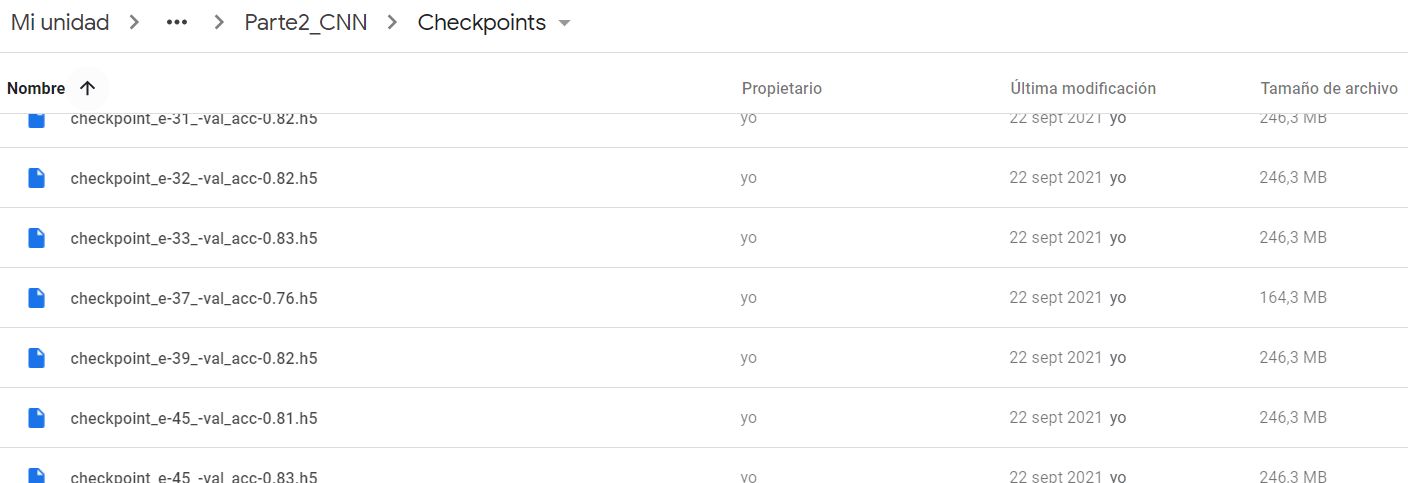

Checkpoint seleccionado:
https://drive.google.com/file/d/1-MZLP4XSJFQNJn7GLXb3KkIPrCbMiZme/view?usp=sharing